<a href="https://colab.research.google.com/github/AlexanderCardarasUCSC/EEG-Decoding-to-Images/blob/main/CSE_247_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EEG decoding to images - Load data

**Complete the following steps before running the cells below**

1.
Change runtime to GPU 

>Runtime > Change runtime type > GPU

2.
For each of the following link, add a Google Drive shortcut to your Drive root folder(My Drive):

>https://drive.google.com/drive/folders/1z8wcew5R7GCeu5s7SSsWw8bUcx1urVmk?usp=sharing

**Mount drive**

In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


**Run the following cells to load eeg and/or image data**

#### Load eeg data

**Uncomment one of the following blocks**

*5-95Hz*

In [ ]:
# !mkdir -p /content/data/eeg
# !cp /content/gdrive/MyDrive/EEG2Image/eeg_5_95_std.pth /content/data/eeg/
# eeg_path = "/content/data/eeg/eeg_5_95_std.pth"

14-70Hz

In [ ]:
# !mkdir -p /content/data/eeg
# !cp /content/gdrive/MyDrive/EEG2Image/eeg_14_70_std.pth /content/data/eeg/
# eeg_path = "/content/data/eeg/eeg_14_70_std.pth"

*55-95Hz*

In [ ]:
!mkdir -p /content/data/eeg
!cp /content/gdrive/MyDrive/EEG2Image/eeg_54_95_std.pth /content/data/eeg/
eeg_path = "/content/data/eeg/eeg_54_95_std.pth"

#### Load image data

In [2]:
!mkdir -p /content/data/images
!wget -q https://raw.githubusercontent.com/AlexanderCardarasUCSC/EEG-Decoding-to-Images/main/image_utils.py /content
!cp /content/gdrive/MyDrive/EEG2Image/data/images.npy /content/data/images
!cp /content/gdrive/MyDrive/EEG2Image/data/image_labels.npy /content/data/images

**Example load image**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import image_utils

In [ ]:
images, labels = image_utils.load_images()

(36000, 64, 64, 3)


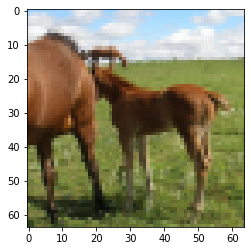

In [ ]:
print(images.shape)
plt.imshow(images[0])

# Baseline GAN

**Complete the following steps before running the cells below**

1. Follow directions in the Load data section to load image data

>Run the cells under the header **Load image data**

**Import libraries**

### Jason's AC-GAN 

In [68]:
# example of fitting an auxiliary classifier gan (ac-gan) on fashion mnsit
from numpy import zeros
from numpy import ones
from numpy import expand_dims
from numpy.random import randn
from numpy.random import randint
from keras.datasets.fashion_mnist import load_data
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv1D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Activation
from keras.layers import Concatenate
from keras.initializers import RandomNormal
from matplotlib import pyplot
import numpy as np
import matplotlib.pyplot as plt
import image_utils

**Discriminator architecture**

In [69]:
# define the standalone discriminator model
def define_discriminator(in_shape=(64,64,3), n_classes=40):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# image input
	in_image = Input(shape=in_shape)
	# downsample to 14x14
	fe = Conv2D(32, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
	fe = LeakyReLU(alpha=0.2)(fe)
	fe = Dropout(0.5)(fe)
	# normal
	fe = Conv2D(64, (3,3), padding='same', kernel_initializer=init)(fe)
	fe = BatchNormalization()(fe)
	fe = LeakyReLU(alpha=0.2)(fe)
	fe = Dropout(0.5)(fe)
	# downsample to 7x7
	fe = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(fe)
	fe = BatchNormalization()(fe)
	fe = LeakyReLU( alpha=0.2)(fe)
	fe = Dropout(0.5)(fe)
	# normal
	fe = Conv2D(256, (3,3), padding='same', kernel_initializer=init)(fe)
	fe = BatchNormalization()(fe)
	fe = LeakyReLU(alpha=0.2)(fe)
	fe = Dropout(0.5)(fe)
	# flatten feature maps
	fe = Flatten()(fe)
	# real/fake output
	out1 = Dense(1, activation='sigmoid')(fe)
	# class label output
	out2 = Dense(n_classes, activation='softmax')(fe)
	# define model
	model = Model(in_image, [out1, out2])
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss=['binary_crossentropy', 'sparse_categorical_crossentropy'], optimizer=opt)
	return model


**Generator architecture**

In [70]:
# define the standalone generator model
def define_generator(latent_dim, n_classes=40):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# label input
	in_label = Input(shape=(1,))
	# embedding for categorical input
	# li = Embedding(n_classes, 50)(in_label)
	li = Embedding(n_classes, 200)(in_label)
	# linear multiplication
	# n_nodes = 7 * 7
	n_nodes = 16 * 16 * 3
	li = Dense(n_nodes, kernel_initializer=init)(li)
	# reshape to additional channel
	# li = Reshape((7, 7, 1))(li)
	li = Reshape((16, 16, 3))(li)
	# image generator input
	in_lat = Input(shape=(latent_dim,))
	# foundation for 7x7 image
	# n_nodes = 384 * 7 * 7
	n_nodes = 384 * 16 * 16
	gen = Dense(n_nodes, kernel_initializer=init)(in_lat)
	gen = Activation('relu')(gen)
	# gen = Reshape((7, 7, 384))(gen)
	gen = Reshape((16, 16, 384))(gen)
	# merge image gen and label input
	merge = Concatenate()([gen, li])
	# upsample to 14x14
	gen = Conv2DTranspose(192, (5,5), strides=(2,2), padding='same', kernel_initializer=init)(merge)
	gen = BatchNormalization()(gen)
	gen = Activation('relu')(gen)
	# upsample to 28x28
	# gen = Conv2DTranspose(1, (5,5), strides=(2,2), padding='same', kernel_initializer=init)(gen)
	gen = Conv2DTranspose(3, (5,5), strides=(2,2), padding='same', kernel_initializer=init)(gen)
	out_layer = Activation('tanh')(gen)
	# define model
	model = Model([in_lat, in_label], out_layer)
	return model

**GAN architecture**

In [71]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	for layer in d_model.layers:
		if not isinstance(layer, BatchNormalization):
			layer.trainable = False
	# connect the outputs of the generator to the inputs of the discriminator
	gan_output = d_model(g_model.output)
	# define gan model as taking noise and label and outputting real/fake and label outputs
	model = Model(g_model.input, gan_output)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss=['binary_crossentropy', 'sparse_categorical_crossentropy'], optimizer=opt)
	return model


**Helper functions**

In [72]:
# load images (60000, 28, 28, 1) (60000,)
def load_real_samples_old():
	# load dataset
	(trainX, trainy), (_, _) = load_data()
	# expand to 3d, e.g. add channels
	X = expand_dims(trainX, axis=-1)
	# convert from ints to floats
	X = X.astype('float32')
	# scale from [0,255] to [-1,1]
	X = (X - 127.5) / 127.5
	return [X, trainy]
  
# splits image data into training and test sets(currently no randomization)
def new_split_data(images, labels, train=0.8, data_per_class=900):
  trainX,trainY,testX,testY = [],[],[],[]
  for i in range(images.shape[0]):
    chunk = i % data_per_class
    if chunk < data_per_class*train:
      trainX.append(images[i])
      trainY.append(labels[i])
    else:
      testX.append(images[i])
      testY.append(labels[i])

  return (np.asarray(trainX), np.asarray(trainY)), (np.asarray(testX), np.asarray(testY))

# load images
def load_real_samples():
  # load dataset
  images, labels = image_utils.load_images()
  (trainX, trainY), (testX, testY) = new_split_data(images, labels)
	# expand to 3d, e.g. add channels
  X = expand_dims(trainX, axis=-1)
	# convert from ints to floats
  X = X.astype('float32')
	# scale from [0,255] to [-1,1]
  X = (X - 127.5) / 127.5
  print(X.shape, trainY.shape)
  return [X, trainY]
 
# select real samples
def generate_real_samples(dataset, n_samples):
	# split into images and labels
	images, labels = dataset
	# choose random instances
	ix = randint(0, images.shape[0], n_samples)
	# select images and labels
	X, labels = images[ix], labels[ix]
	# generate class labels
	y = ones((n_samples, 1))
	return [X, labels], y
 
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=40):
  # generate points in the latent space
  x_input = randn(latent_dim * n_samples)
  # reshape into a batch of inputs for the network
  z_input = x_input.reshape(n_samples, latent_dim)
  # generate labels
  labels = randint(0, n_classes, n_samples)
  return [z_input, labels]
 
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	z_input, labels_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	images = generator.predict([z_input, labels_input])
	# create class labels
	y = zeros((n_samples, 1))
	return [images, labels_input], y

def generate_fake_class_sample(generator, class_label, latent_dim, n_samples):
  # generate points in the latent space
  x_input = randn(latent_dim * n_samples)
  # reshape into a batch of inputs for the network
  z_input = x_input.reshape(n_samples, latent_dim)
  labels_input = np.asarray([class_label for i in range(n_samples)])
  # predict outputs
  images = generator.predict([z_input, labels_input])
  # create class labels
  y = zeros((n_samples, 1))
  return [images, labels_input], y
 
# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, latent_dim, n_samples=100):
	# prepare fake examples
	[X, _], _ = generate_fake_samples(g_model, latent_dim, n_samples)
	# scale from [-1,1] to [0,1]
	X = (X + 1) / 2.0
	# plot images
	for i in range(100):
		# define subplot
		pyplot.subplot(10, 10, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		# pyplot.imshow(X[i, :, :, 0], cmap='gray_r')
		pyplot.imshow(X[i, :, :])
	# save plot to file
	filename1 = 'generated_plot_%04d.png' % (step+1)
	pyplot.savefig(filename1)
	pyplot.close()
	# save the generator model
	filename2 = 'model_%04d.h5' % (step+1)
	g_model.save(filename2)
	print('>Saved: %s and %s' % (filename1, filename2))
 
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=10, n_batch=64):
	# calculate the number of batches per training epoch
	bat_per_epo = int(dataset[0].shape[0] / n_batch)
	# calculate the number of training iterations
	n_steps = bat_per_epo * n_epochs
	# calculate the size of half a batch of samples
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_steps):
		# get randomly selected 'real' samples
		[X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
		# update discriminator model weights
		_,d_r1,d_r2 = d_model.train_on_batch(X_real, [y_real, labels_real])
		# generate 'fake' examples
		[X_fake, labels_fake], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
		# update discriminator model weights
		_,d_f,d_f2 = d_model.train_on_batch(X_fake, [y_fake, labels_fake])
		# prepare points in latent space as input for the generator
		[z_input, z_labels] = generate_latent_points(latent_dim, n_batch)
		# create inverted labels for the fake samples
		y_gan = ones((n_batch, 1))
		# update the generator via the discriminator's error
		_,g_1,g_2 = gan_model.train_on_batch([z_input, z_labels], [y_gan, z_labels])
		# summarize loss on this batch
		print('>%d, dr[%.3f,%.3f], df[%.3f,%.3f], g[%.3f,%.3f]' % (i+1, d_r1,d_r2, d_f,d_f2, g_1,g_2))
		# evaluate the model performance every 'epoch'
		if (i+1) % (bat_per_epo * 10) == 0:
			summarize_performance(i, g_model, latent_dim)

**Train GAN**

In [ ]:
# size of the latent space
# latent_dim = 100
latent_dim = 400
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# load image data
dataset = load_real_samples()
# train model
train(generator, discriminator, gan_model, dataset, latent_dim, n_epochs=20)

In [ ]:
[X, _], _ = generate_fake_class_sample(generator, class_label=0, latent_dim=400, n_samples=16)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0

f, axs = plt.subplots(4,4,figsize=(15,15))
# plot images
for i in range(16):
  axs[i//4,i%4].imshow(X[i])
  axs[i//4,i%4].axis("off")
f.show()


In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(generator, to_file='generator_plot.png', show_shapes=True, show_layer_names=True)
plot_model(discriminator, to_file='discriminator_plot.png', show_shapes=True, show_layer_names=True)

### ThoughtVIZ's  Baseline AC-GAN

**Download model**

In [3]:
!mkdir -p /content/ThoughtViz/models
!wget -q https://raw.githubusercontent.com/ptirupat/ThoughtViz/master/training/models/ac_gan.py -P /content/ThoughtViz/models

**Import libraries**

In [9]:
import os
import numpy as np
import image_utils
from PIL import Image
import math


from random import randint
from PIL import Image
from keras.optimizers import SGD, Adam
from keras.utils import to_categorical
from ThoughtViz.models import ac_gan
import matplotlib.pyplot as plt
import tensorflow as tf
import image_utils

In [5]:
import os.path
import tarfile

import numpy as np
from six.moves import urllib
import tensorflow as tf
import math
import sys
from keras.utils import to_categorical


MODEL_DIR = '/tmp/imagenet'
DATA_URL = 'http://download.tensorflow.org/models/image/imagenet/inception-2015-12-05.tgz'
softmax = None


# Call this function with list of images. Each of elements should be a
# numpy array with values ranging from 0 to 255.
def get_inception_score(images, splits=10):
  assert(type(images) == list)
  assert(type(images[0]) == np.ndarray)
  assert(len(images[0].shape) == 3)
  assert(np.max(images[0]) > 10)
  assert(np.min(images[0]) >= 0.0)
  inps = []
  for img in images:
    img = img.astype(np.float32)
    inps.append(np.expand_dims(img, 0))
  bs = 1
  with tf.compat.v1.Session() as sess:
    preds = []
    n_batches = int(math.ceil(float(len(inps)) / float(bs)))
    for i in range(n_batches):
        sys.stdout.write(".")
        sys.stdout.flush()
        inp = inps[(i * bs):min((i + 1) * bs, len(inps))]
        inp = np.concatenate(inp, 0)
        pred = sess.run(softmax, {'ExpandDims:0': inp})
        preds.append(pred)
    preds = np.concatenate(preds, 0)
    scores = []
    for i in range(splits):
      part = preds[(i * preds.shape[0] // splits):((i + 1) * preds.shape[0] // splits), :]
      kl = part * (np.log(part) - np.log(np.expand_dims(np.mean(part, 0), 0)))
      kl = np.mean(np.sum(kl, 1))
      scores.append(np.exp(kl))
    return np.mean(scores), np.std(scores)


# This function is called automatically.
def _init_inception():
  global softmax
  if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)
  filename = DATA_URL.split('/')[-1]
  filepath = os.path.join(MODEL_DIR, filename)
  if not os.path.exists(filepath):
    def _progress(count, block_size, total_size):
      sys.stdout.write('\r>> Downloading %s %.1f%%' % (
          filename, float(count * block_size) / float(total_size) * 100.0))
      sys.stdout.flush()
    filepath, _ = urllib.request.urlretrieve(DATA_URL, filepath, _progress)
    print()
    statinfo = os.stat(filepath)
    print('Succesfully downloaded', filename, statinfo.st_size, 'bytes.')
  tarfile.open(filepath, 'r:gz').extractall(MODEL_DIR)
  with tf.compat.v1.gfile.FastGFile(os.path.join(
      MODEL_DIR, 'classify_image_graph_def.pb'), 'rb') as f:
    graph_def = tf.compat.v1.GraphDef()
    graph_def.ParseFromString(f.read())
    _ = tf.import_graph_def(graph_def, name='')
  # Works with an arbitrary minibatch size.
  with tf.compat.v1.Session() as sess:
    pool3 = sess.graph.get_tensor_by_name('pool_3:0')
    ops = pool3.graph.get_operations()
    for op_idx, op in enumerate(ops):
        for o in op.outputs:
            shape = o.get_shape()
            shape = [s for s in shape]
            new_shape = []
            for j, s in enumerate(shape):
                if s == 1 and j == 0:
                    new_shape.append(None)
                else:
                    new_shape.append(s)
            o.set_shape(tf.TensorShape(new_shape))
    w = sess.graph.get_operation_by_name("softmax/logits/MatMul").inputs[1]
    logits = tf.matmul(tf.squeeze(pool3, [1, 2]), w)
    softmax = tf.nn.softmax(logits)


if softmax is None:
  _init_inception()

>> Downloading inception-2015-12-05.tgz 100.0%
Succesfully downloaded inception-2015-12-05.tgz 88931400 bytes.
Instructions for updating:
Use tf.gfile.GFile.


**Helper Functions**

In [10]:
def trim_classes(images, labels, max_classes=10):
  return images[0:900*max_classes], labels[0:900*max_classes]

def combine_rgb_images(generated_images):
    num = generated_images.shape[0]
    width = int(math.sqrt(num))
    height = int(math.ceil(float(num)/width))
    shape = generated_images.shape[1:3]
    image = np.zeros((height*shape[0], width*shape[1], 3),
                     dtype=generated_images.dtype)
    for index, img in enumerate(generated_images):
        i = int(index/width)
        j = index % width
        image[i*shape[0]:(i+1)*shape[0], j*shape[1]:(j+1)*shape[1], :] = img[:, :, :]
    return image

def load_data(num_classes):
    images, labels = image_utils.load_images()
    images, labels = trim_classes(images, labels, num_classes)
    (x_train, y_train), (x_test, y_test) = image_utils.split_data(images, labels)
    x_train = (x_train.astype(np.float32) - 127.5) / 127.5
    x_test = (x_test.astype(np.float32) - 127.5) / 127.5
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)
    return (x_train, y_train), (x_test, y_test)

def train_gan(input_noise_dim, batch_size, epochs, model_save_dir, output_dir, num_classes):
    
    (x_train, y_train), (x_test, y_test) = load_data(num_classes)
    print(y_train.shape)
    adam_lr = 0.001
    adam_beta_1 = 0.5

    d = ac_gan.discriminator_model_rgb((64,64), num_classes)
    d_optim = Adam(lr=adam_lr, beta_1=adam_beta_1)
    d.compile(loss=['binary_crossentropy','categorical_crossentropy'], optimizer=d_optim)
    d.trainable = True

    g = ac_gan.generator_model_rgb(input_noise_dim + num_classes)
    g_optim = Adam(lr=adam_lr, beta_1=adam_beta_1)
    g.compile(loss='categorical_crossentropy', optimizer=g_optim)

    d_on_g = ac_gan.generator_containing_discriminator(input_noise_dim + num_classes, g, d)
    d_on_g.compile(loss=['binary_crossentropy','categorical_crossentropy'], optimizer=g_optim)

    g.summary()
    d.summary()
    
    for epoch in range(epochs):
        print("Epoch is ", epoch)

        print("Number of batches", int(x_train.shape[0]/batch_size))

        for index in range(int(x_train.shape[0]/batch_size)):
            # generate noise from a normal distribution
            noise = np.random.uniform(-1, 1, (batch_size, input_noise_dim))

            random_labels = [randint(0, 9) for i in range(batch_size)]

            one_hot_vectors = [to_categorical(label, 10) for label in random_labels]

            conditioned_noise = []
            for i in range(batch_size):
                conditioned_noise.append(np.append(noise[i], one_hot_vectors[i]))
            conditioned_noise = np.array(conditioned_noise)

            # get real images and corresponding labels
            real_images = x_train[index * batch_size:(index + 1) * batch_size]
            real_labels = y_train[index * batch_size:(index + 1) * batch_size]

            # generate fake images using the generator
            generated_images = g.predict(conditioned_noise, verbose=0)

            # discriminator loss of real images
            d_loss_real = d.train_on_batch(real_images, [np.array([1] * batch_size), np.array(real_labels)])
            # discriminator loss of fake images
            d_loss_fake = d.train_on_batch(generated_images, [np.array([0] * batch_size), np.array(one_hot_vectors).reshape(batch_size, num_classes)])
            d_loss = (d_loss_fake[0] + d_loss_real[0]) * 0.5

            # save generated images at intermediate stages of training
            if index % 250 == 0:
                image = combine_rgb_images(generated_images)
                image = image * 255.0
                img_save_path = os.path.join(output_dir, str(epoch) + "_g_" + str(index) + ".png")
                Image.fromarray(image.astype(np.uint8)).save(img_save_path)

            d.trainable = False
            # generator loss
            g_loss = d_on_g.train_on_batch(conditioned_noise, [np.array([1] * batch_size), np.array(one_hot_vectors).reshape(batch_size, num_classes)])
            d.trainable = True

        # test_image_count = 50000
        test_image_count = x_train.shape[0]
        test_noise = np.random.uniform(-1, 1, (test_image_count, input_noise_dim))
        test_labels = [randint(0, 9) for i in range(test_image_count)]
        one_hot_vectors_test = [to_categorical(label, 10) for label in test_labels]

        conditioned_noise_test = []
        for i in range(test_image_count):
            conditioned_noise_test.append(np.append(test_noise[i], one_hot_vectors_test[i]))
        conditioned_noise_test = np.array(conditioned_noise_test)

        test_images = g.predict(conditioned_noise_test, verbose=0)
        test_images = test_images * 255.0
        
        if epoch % 10 == 0:        
            inception_score = get_inception_score([test_image for test_image in test_images], splits=10)

        print("Epoch %d d_loss : %f" % (epoch, d_loss))
        print("Epoch %d g_loss : %f" % (epoch, g_loss[0]))
        print("Epoch %d inception_score : %f" % (epoch, inception_score[0]))

        # save generator and discriminator models along with the weights
        g.save(os.path.join(model_save_dir, 'generator_' + str(epoch)), overwrite=True, include_optimizer=True)
        d.save(os.path.join(model_save_dir, 'discriminator_' + str(epoch)), overwrite=True, include_optimizer=True)

**Train GAN**

In [11]:
batch_size = 100
run_id = 1
n_epochs = 500
input_dim = 100
n_classes=10

model_save_dir = os.path.join('./saved_models/baseline_acgan/', 'run_' + str(run_id))
if not os.path.exists(model_save_dir):
    os.makedirs(model_save_dir)

output_dir = os.path.join('./outputs/baseline_acgan/', 'run_' + str(run_id))
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

train_gan(input_dim, batch_size, n_epochs, model_save_dir, output_dir, n_classes)

(7200, 10)
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 110)]             0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 110)               440       
_________________________________________________________________
dense_2 (Dense)              (None, 8192)              909312    
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 512)         0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 4, 4, 512)         2048      
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 256)         3277056   
_________________________________________________________________
batch_normalization_7 (Batch (None, 8, 8, 256)  

KeyboardInterrupt: ignored

In [96]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.144])

def resize_images(images, size=(28,28)):
  temp = []
  for img in images:
    temp.append(np.array(Image.fromarray(img).resize(size, Image.ANTIALIAS)))
  return np.asarray(temp)

def trim_classes(images, labels, max_classes=10):
  return images[0:900*max_classes], labels[0:900*max_classes]

In [81]:
images, labels = image_utils.load_images()
images = rgb2gray(images)
print(images.shape)
images = resize_images(images)
print(images.shape)
(x_train, y_train), (x_test, y_test) = image_utils.split_data(images, labels)

(36000, 64, 64)
(36000, 28, 28)


**Download Trained Model**

In [16]:
!mkdir -p /content/models/ThoughtViz
!cp /content/gdrive/MyDrive/EEG2Image/models/ThoughtViz/baseline\ acgan/run_1/generator_100/saved_model.pb  /content/models/ThoughtViz/
!mv /content/models/ThoughtViz/saved_model.pb /content/models/ThoughtViz/generator.pb
!cp /content/gdrive/MyDrive/EEG2Image/models/ThoughtViz/baseline\ acgan/run_1/discriminator_100/saved_model.pb  /content/models/ThoughtViz/
!mv /content/models/ThoughtViz/saved_model.pb /content/models/ThoughtViz/discriminator.pb

In [22]:
!mkdir -p /content/models/ThoughtViz
!cp -r /content/gdrive/MyDrive/EEG2Image/models/ThoughtViz/baseline\ acgan/run_1/generator_100 /content/models/ThoughtViz/
!cp -r /content/gdrive/MyDrive/EEG2Image/models/ThoughtViz/baseline\ acgan/run_1/discriminator_100 /content/models/ThoughtViz/


**Load Model**

In [31]:
import tensorflow as tf
import pickle
import random

import keras.backend as K
from PIL import Image
from keras.models import load_model
from keras.utils import to_categorical


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:434: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


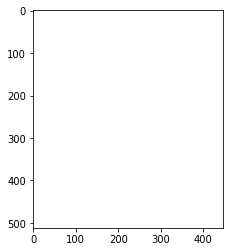

In [45]:
K.set_learning_phase(False)

input_noise_dim = 100
batch_size = 50

noise = np.random.uniform(-1, 1, (batch_size, input_noise_dim))

random_labels = np.random.randint(0, 10, batch_size)

conditioned_noise = []
for i in range(batch_size):
    conditioned_noise.append(np.append(noise[i], to_categorical(0, 10)))
conditioned_noise = np.array(conditioned_noise)

g = load_model("/content/models/ThoughtViz/generator_100")

# generate images using the generator
generated_images = g.predict(conditioned_noise, verbose=0)

image = combine_rgb_images(generated_images)
image = image * 127.5 + 127.5
plt.imshow(image)
img = Image.fromarray(image.astype(np.uint8))
img.show()
img.save("test.png")

In [28]:
import pickle
import random

import keras.backend as K
from PIL import Image
from keras.models import load_model
from keras.utils import to_categorical

from layers.mog_layer import *
from utils.image_utils import *


class Tests():

    def test_deligan_baseline(self, generator_model):
        K.set_learning_phase(False)

        input_noise_dim = 100
        batch_size = 50

        noise = np.random.uniform(-1, 1, (batch_size, input_noise_dim))

        random_labels = np.random.randint(0, 10, batch_size)

        conditioned_noise = []
        for i in range(batch_size):
            conditioned_noise.append(np.append(noise[i], to_categorical(random_labels[i], 10)))
        conditioned_noise = np.array(conditioned_noise)

        g = load_model(generator_model, custom_objects={'MoGLayer': MoGLayer})

        # generate images using the generator
        generated_images = g.predict(conditioned_noise, verbose=0)

        image = combine_rgb_images(generated_images)
        image = image * 127.5 + 127.5
        img = Image.fromarray(image.astype(np.uint8))
        img.show()

    def test_deligan_final(self, generator_model, classifier_model, eeg_pkl_file):
        K.set_learning_phase(False)

        # load EEG data
        eeg_data = pickle.load(open(eeg_pkl_file, "rb"), encoding='bytes')
        classifier = load_model(classifier_model)

        x_test = eeg_data[b'x_test']
        y_test = eeg_data[b'y_test']
        y_test = [np.argmax(y) for y in y_test]
        layer_index = 9

        # keras way of getting the output from an intermediate layer
        get_nth_layer_output = K.function([classifier.layers[0].input], [classifier.layers[layer_index].output])

        layer_output = get_nth_layer_output([x_test])[0]

        input_noise_dim = 100
        batch_size = 50

        noise = np.random.uniform(-1, 1, (batch_size, input_noise_dim))

        random_labels = np.random.randint(0, 10, batch_size)

        eeg_feature_vectors = [layer_output[random.choice(np.where(y_test == random_label)[0])] for random_label in random_labels]

        noises, conditionings = [], []
        for i in range(batch_size):
            noises.append(noise[i])
            conditionings.append(eeg_feature_vectors[i])

        g = load_model(generator_model, custom_objects={'MoGLayer': MoGLayer})

        # generate images using the generator
        generated_images = g.predict([np.array(noises), np.array(conditionings)], verbose=0)

        image = combine_rgb_images(generated_images)
        image = image * 127.5 + 127.5
        img = Image.fromarray(image.astype(np.uint8))
        img.show()


if __name__ == '__main__':
    tests = Tests()
    #tests.test_deligan_baseline('../models/gan_models/baseline/deligan/image/generator.model')
    tests.test_deligan_final('../models/gan_models/final/image/generator.model',
                       '../models/eeg_models/image/run_final.h5',
                       '../data/eeg/image/data.pkl')

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 110)]             0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 110)               440       
_________________________________________________________________
dense_2 (Dense)              (None, 8192)              909312    
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 512)         0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 4, 4, 512)         2048      
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 256)         3277056   
_________________________________________________________________
batch_normalization_7 (Batch (None, 8, 8, 256)         1024

# ThoughtViz

**Complete the following steps before running the cells below**

1.
Change runtime to GPU 

>Runtime > Change runtime type > GPU

2.
For each of the following links, add a Google Drive shortcut to your Drive root folder(My Drive):

>https://drive.google.com/file/d/1atP9CsjWIT-hg3fX--fcC1hg0uvg9bEH/view

>https://drive.google.com/file/d/1x32IulYeBVmkshEKweijMX3DK1Wu8odx/view

>https://drive.google.com/file/d/1cq8RTBiwqO-Jo0TZjBNlRHZEhjKDknKP/view

>https://drive.google.com/file/d/1U9qtN1SlOS3dzd2BwWWHhJiMz_0yNW9U/view

>https://drive.google.com/file/d/1uFFhvTsU2nmdaecR2WPWsiGJfgI3as1_/view

**Mount drive and download project**

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

In [ ]:
!git clone "https://github.com/ptirupat/ThoughtViz.git" "/content/ThoughtViz"

**Unzip project files**

In [ ]:
!unzip -q "/content/gdrive/My Drive/data.zip" -d "/content/ThoughtViz" 
!unzip -q "/content/gdrive/My Drive/images.zip" -d "/content/ThoughtViz/training"
!unzip -q "/content/gdrive/My Drive/eeg_models.zip" -d "/content/ThoughtViz/models" 
!unzip -q "/content/gdrive/My Drive/trained_classifier_models.zip" -d "/content/ThoughtViz/training"
!unzip -q "/content/gdrive/My Drive/gan_models.zip" -d "/content/ThoughtViz/models"
!echo "Download Finished!"

**Update outdated module calls and make code compatible with colab environment**

In [ ]:
# Update Keras module structure
!sed -i "s/keras.layers/keras/" ThoughtViz/layers/mog_layer.py

# Change System Path
!sed -i "1i import sys\nsys.path.insert(0,'/content/ThoughtViz')\n" /content/ThoughtViz/testing/test.py
!sed -i "s/\..\//\/content\/ThoughtViz\//" ThoughtViz/testing/test.py

# Rename GAN model directory to match code
!mv /content/ThoughtViz/models/gan_models/thoughtviz/ /content/ThoughtViz/models/gan_models/final/

**Test code**

Note: Images are not saved by default. 
>To save the output image, you must edit the *ThoughtViz/testing/test.py* file and add the line **img.save('output.png')** after *img.show()* in the *test_deligan_final* function. 

In [ ]:
!python3 ThoughtViz/testing/test.py

# EEG decoding to images - Converting Data

**Convert to NPY**

Code provided by: *https://github.com/perceivelab/eeg_visual_classification/blob/main/eeg_signal_classification.py*

In [ ]:
import torch

def pth_to_npy(path):
      torch_file = torch.load(path)

      torch_dataset = torch_file["dataset"]
      torch_labels = torch_file["labels"]
      torch_images = torch_file["images"]
      torch_size = len(torch_dataset)

      return torch_dataset, torch_labels, torch_images, torch_size

torch_dataset, torch_labels, torch_images, torch_size = pth_to_npy(data_path)
# # Dataset class
# class EEGDataset:
    
#     # Constructor
#     def __init__(self, eeg_signals_path):
#         # Load EEG signals
#         loaded = torch.load(eeg_signals_path)
#         if opt.subject!=0:
#             self.data = [loaded['dataset'][i] for i in range(len(loaded['dataset']) ) if loaded['dataset'][i]['subject']==opt.subject]
#         else:
#             self.data=loaded['dataset']        
#         self.labels = loaded["labels"]
#         self.images = loaded["images"]
        
#         # Compute size
#         self.size = len(self.data)

#     # Get size
#     def __len__(self):
#         return self.size

#     # Get item
#     def __getitem__(self, i):
#         # Process EEG
#         eeg = self.data[i]["eeg"].float().t()
#         eeg = eeg[opt.time_low:opt.time_high,:]

#         if opt.model_type == "model10":
#             eeg = eeg.t()
#             eeg = eeg.view(1,128,opt.time_high-opt.time_low)
#         # Get label
#         label = self.data[i]["label"]
#         # Return
#         return eeg, label

In [ ]:
print("size:", torch_size)

size: 11965


In [ ]:
# print("dataset 0:", torch_dataset[0])
eeg = torch_dataset[0]["eeg"]
image_num = torch_dataset[0]["image"]
label = torch_dataset[0]["label"]
subject = torch_dataset[0]["subject"]

print("eeg data:", eeg)
print("image number:", image_num)
print("image label:", label)
print("participant number:", subject)

trimmed_eeg = eeg.float().t()[40:460]
print("eeg data trimmed:", trimmed_eeg)

numpy_eeg = trimmed_eeg.numpy()
print("eeg data trimmed+numpy:", numpy_eeg)


eeg data: tensor([[-0.0098,  0.0195,  0.0620,  ...,  0.0638,  0.0120, -0.0118],
        [-0.0045,  0.1303,  0.2673,  ...,  0.0894,  0.0342, -0.0082],
        [ 0.0215, -0.2017, -0.4305,  ..., -0.2022, -0.0940,  0.0188],
        ...,
        [ 0.0160,  0.0707,  0.1005,  ...,  0.2066,  0.1156,  0.0036],
        [-0.0046, -0.0084, -0.0119,  ...,  0.0007, -0.0026, -0.0053],
        [ 0.0040,  0.0419,  0.0665,  ...,  0.0765,  0.0309, -0.0063]])
image number: 0
image label: 10
participant number: 4
eeg data trimmed: tensor([[-0.4191,  0.0019, -0.2101,  ..., -0.1909, -0.0154, -0.0490],
        [-0.3855,  0.0083, -0.1807,  ..., -0.1959, -0.0153, -0.0395],
        [-0.3205,  0.0448, -0.1669,  ..., -0.2303, -0.0169, -0.0532],
        ...,
        [ 0.3540,  0.2597,  0.3852,  ...,  0.3877,  0.0131,  0.1309],
        [ 0.3000,  0.1950,  0.4775,  ...,  0.3140,  0.0086,  0.0727],
        [ 0.2586,  0.1368,  0.5080,  ...,  0.2619,  0.0052,  0.0441]])
eeg data trimmed+numpy: [[-0.41908935  0.00189896 

In [ ]:
print("label 0:", torch_labels[0])
print("label 1:", torch_labels[1])

label 0: n02389026
label 1: n03888257


In [ ]:
print("image 0:", torch_images[0])
print("image 1:", torch_images[1])

for i in range(0,10):
  print(torch_images[i])

image 0: n02951358_31190
image 1: n03452741_16744
n02951358_31190
n03452741_16744
n04069434_10318
n02951358_34807
n03452741_5499
n03376595_247
n02906734_14010
n03452741_2982
n02607072_5873
n02510455_96034


# Visualization

**Download and Import Packages**

In [ ]:
!pip install -U mne
!pip install pyEDFlib

     |████████████████████████████████| 6.9MB 6.3MB/s 
     |████████████████████████████████| 1.2MB 7.5MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for pyEDFlib: filename=pyEDFlib-0.1.20-cp37-cp37m-linux_x86_64.whl size=929386 sha256=0786962b6603f9645ab869be321052ab038c0bce619e7ac1a549112a00fb4d4a
  Stored in directory: /root/.cache/pip/wheels/0d/be/b5/574f8b99ad9ac2ecf78e0c5271040b5aff999febfe655b97a4
Successfully built pyEDFlib


In [ ]:
%matplotlib inline
import mne
import os
import numpy as np
from pyedflib import highlevel

**Define Visualization Functions**

In [ ]:
def create_edf(npy_path, name):
  data = np.load(npy_path)
  # [128,440,11965]
  signals = list(data.T[:,:,:])
  channel_names = list('ch'+str(i) for i in range(0,128))
  signal_headers = highlevel.make_signal_headers(channel_names, sample_rate=1000)
  header = highlevel.make_header()
  highlevel.write_edf(name, signals, signal_headers, header)

def create_edf2(npy_path, name):
  data = np.load(npy_path)
  # [128,11965,440]
  signals = list(data.transpose(2,0,1)[0:ch,0:100,:])
  channel_names = list('ch'+str(i) for i in range(0,128))
  signal_headers = highlevel.make_signal_headers(channel_names, sample_rate=1000)
  header = highlevel.make_header()
  highlevel.write_edf(name, signals, signal_headers, header)

def visualizeData(path):
  raw = mne.io.read_raw_edf(path,preload=True);
  print(raw)
  raw.plot_psd(area_mode='range', fmin=15, fmax=70.0, show=False, average=True);
  raw.plot(duration=2, scalings=0.000002)

In [ ]:
data_path = '/content/gdrive/MyDrive/EEG2Image/data/eeg_14_70.npy'
test_path = '/content/test_file.edf'
rand_path = '/content/edf_file.edf'

In [ ]:
print(data.shape)
print(data[::1,1].shape)
print(data[::1,2].shape)
print(data[1::].shape)
print(data[2::].shape)
print(data.T[0,0].shape)
print(data.T.shape)
print(data.T[:,:,0:10].shape)
print(data.T[:,:,0:10].reshape(128,440*10).shape)
print(data.transpose(2,0,1).shape)
print(data.transpose(2,0,1)[:,0:10,:].shape)
data.transpose(2,0,1)[0:10,0:10,:].reshape((128,440*10)).shape


(11965, 440, 128)
(11965, 128)
(11965, 128)
(11964, 440, 128)
(11963, 440, 128)
(11965,)
(128, 440, 11965)
(128, 440, 10)
(128, 4400)
(128, 11965, 440)
(128, 10, 440)


(128, 4400)

Extracting EDF parameters from /content/test_file.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 43999  =      0.000 ...    43.999 secs...
<RawEDF | test_file.edf, 5 x 44000 (44.0 s), ~1.7 MB, data loaded>
Effective window size : 2.048 (s)


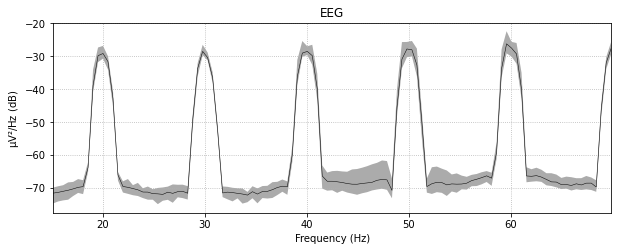

/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)


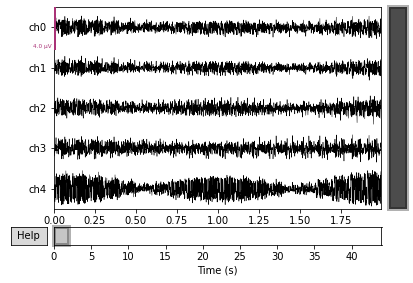

In [ ]:
# write an edf file
ch = 5
signals = list(data.T[0:ch,:,0:100].reshape(ch,440*100))
channel_names = list('ch'+str(i) for i in range(0,ch))
signal_headers = highlevel.make_signal_headers(channel_names, sample_rate=1000)
header = highlevel.make_header(patientname='patient_x', gender='Female')
highlevel.write_edf('test_file.edf', signals, signal_headers, header)

visualizeData(test_path)

Extracting EDF parameters from /content/test_file.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 43999  =      0.000 ...    43.999 secs...
<RawEDF | test_file.edf, 5 x 44000 (44.0 s), ~1.7 MB, data loaded>
Effective window size : 2.048 (s)


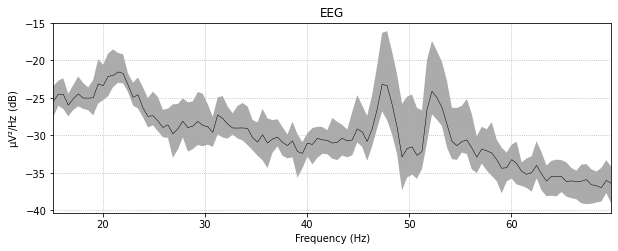

/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)


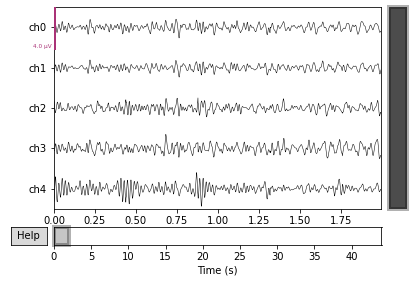

In [ ]:
# write an edf file
ch = 5
signals = list(data.transpose(2,0,1)[0:ch,0:100,:])
channel_names = list('ch'+str(i) for i in range(0,ch))
signal_headers = highlevel.make_signal_headers(channel_names, sample_rate=1000)
header = highlevel.make_header()
highlevel.write_edf('test_file.edf', signals, signal_headers, header)

visualizeData(test_path)

Extracting EDF parameters from /content/test_file.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 43999  =      0.000 ...    43.999 secs...
<RawEDF | test_file.edf, 50 x 44000 (44.0 s), ~16.8 MB, data loaded>
Effective window size : 2.048 (s)


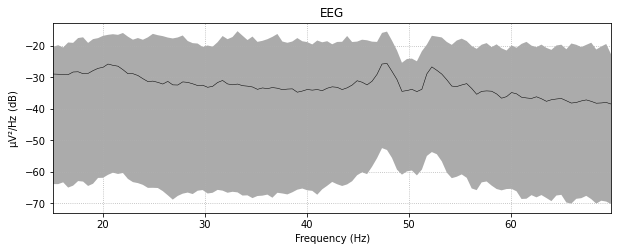

/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)


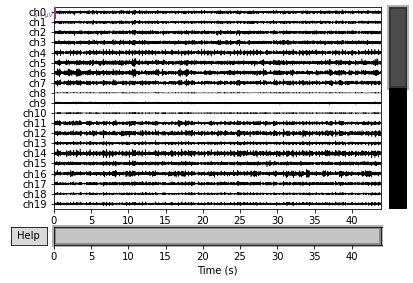

In [ ]:
# write an edf file
ch = 50
signals = list(data.transpose(2,0,1)[0:ch,0:100,:])
channel_names = list('ch'+str(i) for i in range(0,ch))
signal_headers = highlevel.make_signal_headers(channel_names, sample_rate=1000)
header = highlevel.make_header()
highlevel.write_edf('test_file.edf', signals, signal_headers, header)

visualizeData(test_path)

Extracting EDF parameters from /content/test_file.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 43999  =      0.000 ...    43.999 secs...
<RawEDF | test_file.edf, 100 x 44000 (44.0 s), ~33.7 MB, data loaded>
Effective window size : 2.048 (s)


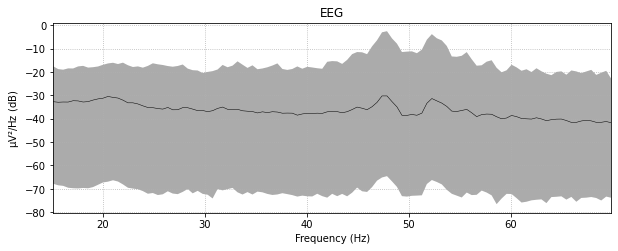

/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)


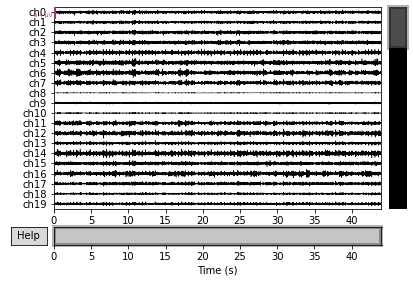

Extracting EDF parameters from /content/test_file.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 439999  =      0.000 ...   439.999 secs...
<RawEDF | test_file.edf, 100 x 440000 (440.0 s), ~335.8 MB, data loaded>
Effective window size : 2.048 (s)


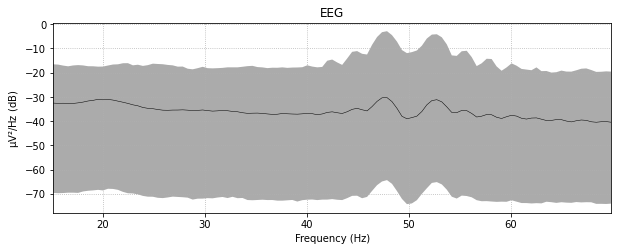

/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)


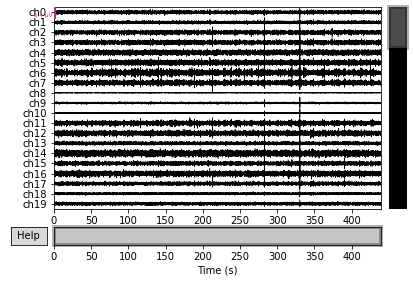

In [ ]:
visualizeData(test_path)

Extracting EDF parameters from /content/test_file.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 43999  =      0.000 ...    43.999 secs...
<RawEDF | test_file.edf, 100 x 44000 (44.0 s), ~33.7 MB, data loaded>
Effective window size : 2.048 (s)


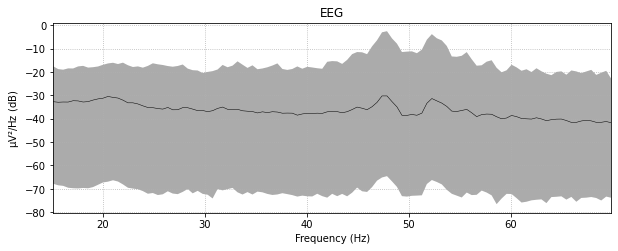

/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)


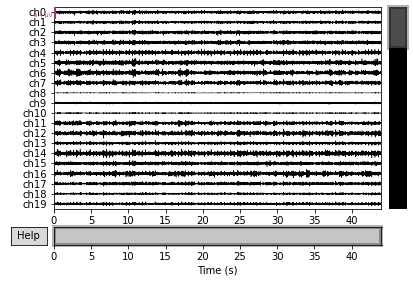

In [ ]:
visualizeData(test_path)

**LSTM stuff**

In [ ]:
# Code goes here #

**GAN stuff**

In [ ]:
# Code goes here #

**Test Code**

In [ ]:
# Code goes here #